# Demand Forecasting Project
## Data Science Internship Project

第一周： 数据处理
1. 数据加载
2. 探索性数据分析（EDA）
3. 离群值检测和清理
4. 数据预处理
5. 特征工程
6. 数据拆分和验证

第二周： 模型训练
1. 模型训练
2. 模型评估
3. 模型调参
4. 模型预测
5. 模型保存和加载
6. 模型部署

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Pandas version: 1.5.3
NumPy version: 1.25.0
Matplotlib version: 3.7.1
Seaborn version: 0.12.2


## 1. 数据加载

In [17]:
# Load training and test data
train_data = pd.read_csv('../archive/train_0irEZ2H.csv')
test_data = pd.read_csv('../archive/test_nfaJ3J5.csv')

print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

print("\nTraining data preview:")
display(train_data.head())

print("\nTest data preview:")
display(test_data.head())

Training data shape: (150150, 9)
Test data shape: (13860, 8)

Training data preview:


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52



Test data preview:


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0
2,212647,16/07/13,8091,216425,133.9500,133.9500,0,0
3,212648,16/07/13,8091,216233,133.9500,133.9500,0,0
4,212649,16/07/13,8091,217390,176.7000,176.7000,0,0


In [18]:
# Check data types and basic info
print("Training data info:")
train_data.info()

print("\nTest data info:")
test_data.info()

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB

Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13860 entries, 0 to 13859
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   record_ID        13860 non-null  int64  
 1   week             13860

## 2. EDA

In [19]:
print("Training data description:")
display(train_data.describe())

print("Test data description:")
display(test_data.describe())

Training data description:


,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150.000000,150150.000000,150149.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,9199.422511,254761.132468,206.626751,219.425927,0.095611,0.133200,51.674206
std,61386.037861,615.591445,85547.306447,103.308516,110.961712,0.294058,0.339792,60.207904
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


Test data description:


,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
count,13860.000000,13860.000000,13860.000000,13860.000000,13860.000000,13860.000000,13860.000000
mean,222460.146392,9199.422511,254761.132468,212.188874,223.922660,0.086580,0.133333
std,5668.258490,615.611603,85550.107852,93.138162,103.429522,0.281229,0.339947
min,212645.000000,8023.000000,216233.000000,65.550000,70.537500,0.000000,0.000000
25%,217557.750000,8562.000000,217217.000000,132.525000,137.512500,0.000000,0.000000
50%,222466.500000,9371.000000,222087.000000,213.037500,218.737500,0.000000,0.000000
75%,227367.250000,9731.000000,245338.000000,241.537500,261.487500,0.000000,0.000000
max,232287.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000


In [20]:
# Check for missing values
print("Missing values in training data:")
missing_train = train_data.isnull().sum()
print(missing_train[missing_train > 0])

print("\nMissing values in test data:")
missing_test = test_data.isnull().sum()
print(missing_test[missing_test > 0])

Missing values in training data:
total_price    1
dtype: int64

Missing values in test data:
Series([], dtype: int64)


In [21]:
# Convert week column to datetime
train_data['week'] = pd.to_datetime(train_data['week'], format='%y/%m/%d')
test_data['week'] = pd.to_datetime(test_data['week'], format='%y/%m/%d')

print("Date range in training data:")
print(f"Start: {train_data['week'].min()}, End: {train_data['week'].max()}")

print("\nDate range in test data:")
print(f"Start: {test_data['week'].min()}, End: {test_data['week'].max()}")

Date range in training data:
Start: 2001-01-13 00:00:00, End: 2031-10-11 00:00:00

Date range in test data:
Start: 2001-10-13 00:00:00, End: 2030-07-13 00:00:00


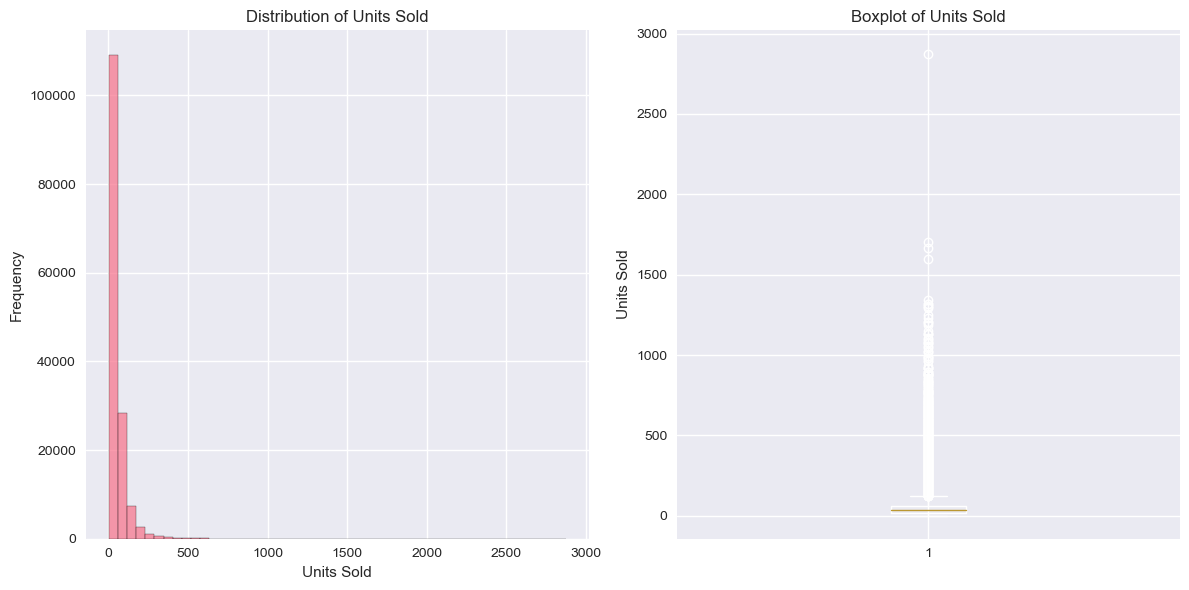

Statistics for units_sold:
Mean: 51.67
Median: 35.00
Std: 60.21
Min: 1
Max: 2876


In [22]:
# Distribution of target variable (units_sold)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_data['units_sold'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(train_data['units_sold'])
plt.title('Boxplot of Units Sold')
plt.ylabel('Units Sold')

plt.tight_layout()
plt.show()

print(f"Statistics for units_sold:")
print(f"Mean: {train_data['units_sold'].mean():.2f}")
print(f"Median: {train_data['units_sold'].median():.2f}")
print(f"Std: {train_data['units_sold'].std():.2f}")
print(f"Min: {train_data['units_sold'].min()}")
print(f"Max: {train_data['units_sold'].max()}")

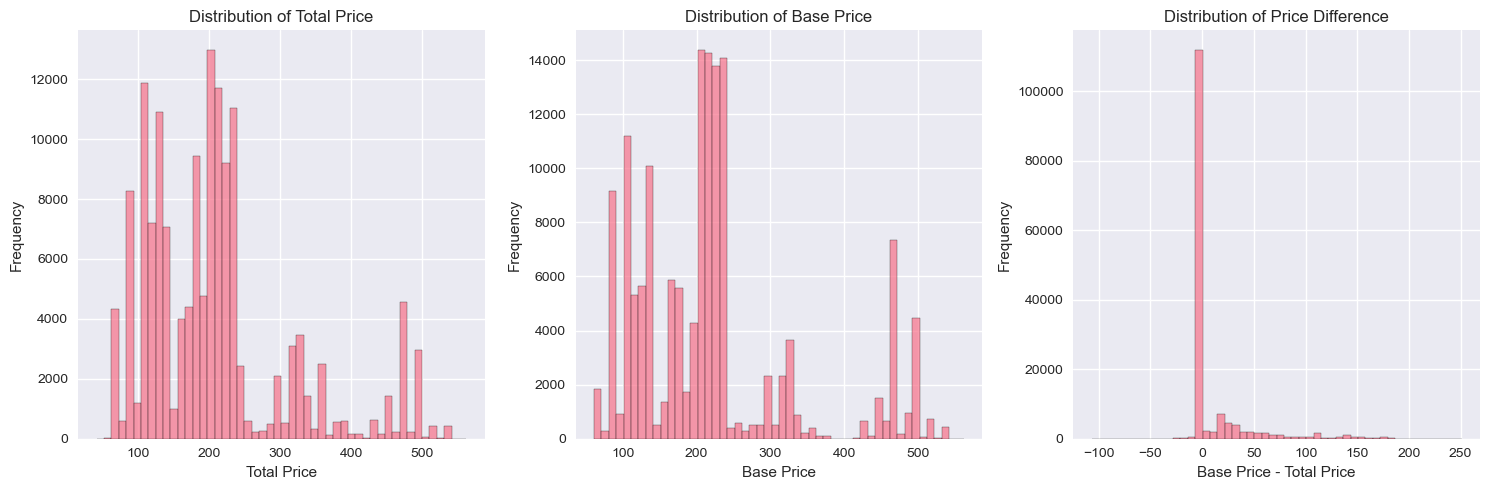

In [23]:
# Price analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_data['total_price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Total Price')
plt.xlabel('Total Price')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(train_data['base_price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Base Price')
plt.xlabel('Base Price')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
price_diff = train_data['base_price'] - train_data['total_price']
plt.hist(price_diff, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Price Difference')
plt.xlabel('Base Price - Total Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

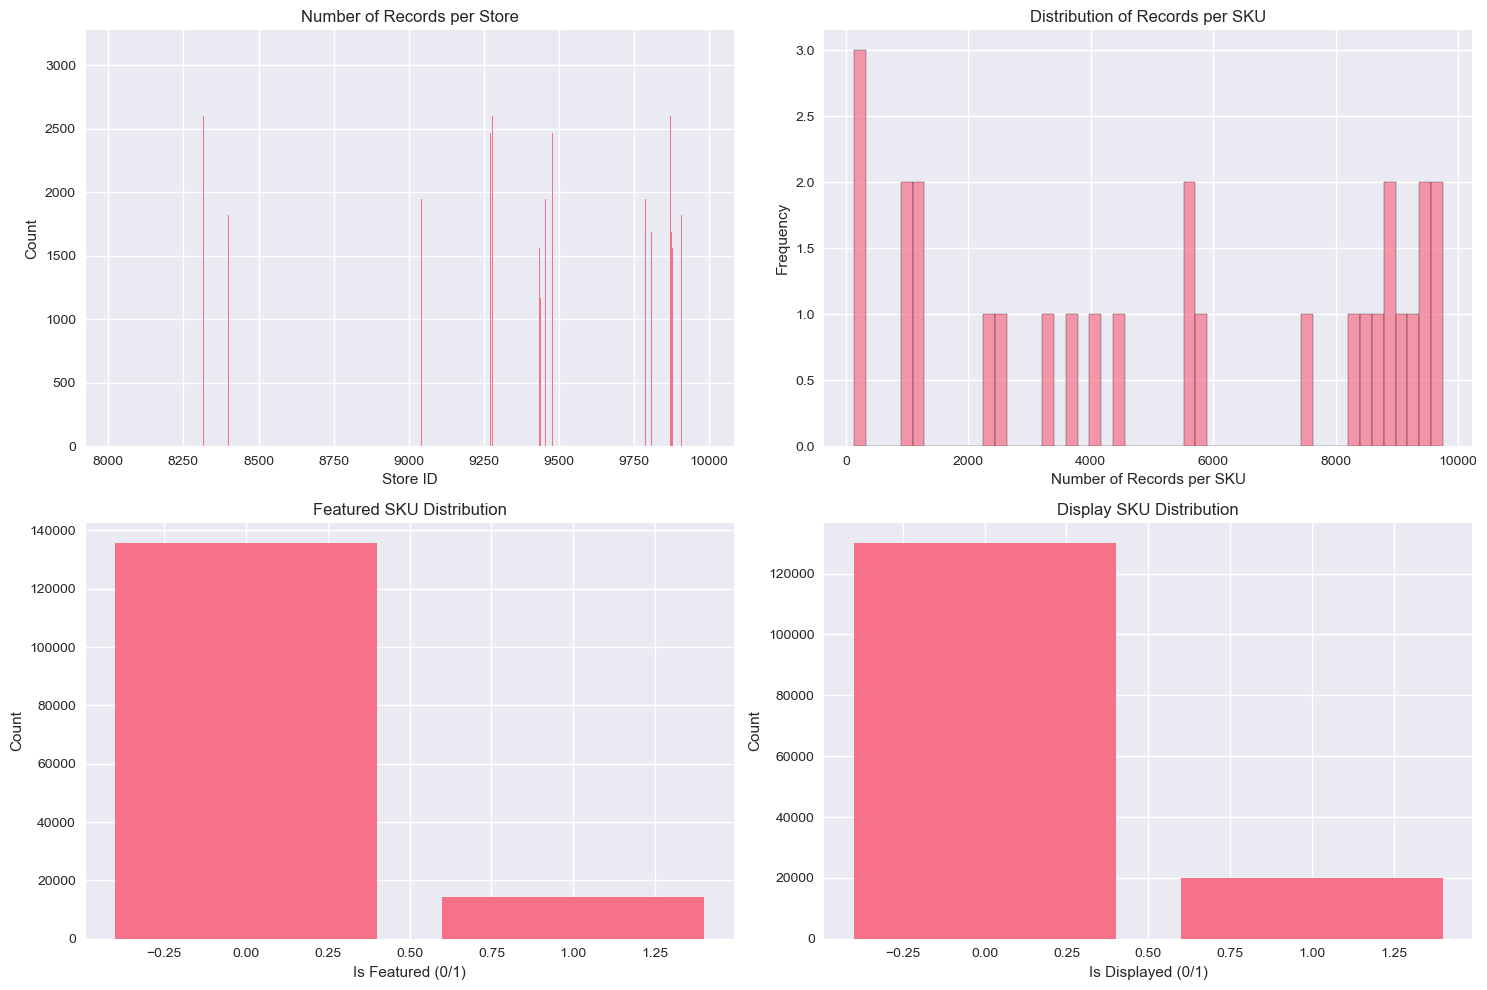

In [24]:
# Categorical variables analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Store analysis
store_counts = train_data['store_id'].value_counts()
axes[0, 0].bar(store_counts.index, store_counts.values)
axes[0, 0].set_title('Number of Records per Store')
axes[0, 0].set_xlabel('Store ID')
axes[0, 0].set_ylabel('Count')

# SKU analysis
sku_counts = train_data['sku_id'].value_counts()
axes[0, 1].hist(sku_counts.values, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Records per SKU')
axes[0, 1].set_xlabel('Number of Records per SKU')
axes[0, 1].set_ylabel('Frequency')

# Promotion features
featured_counts = train_data['is_featured_sku'].value_counts()
axes[1, 0].bar(featured_counts.index, featured_counts.values)
axes[1, 0].set_title('Featured SKU Distribution')
axes[1, 0].set_xlabel('Is Featured (0/1)')
axes[1, 0].set_ylabel('Count')

display_counts = train_data['is_display_sku'].value_counts()
axes[1, 1].bar(display_counts.index, display_counts.values)
axes[1, 1].set_title('Display SKU Distribution')
axes[1, 1].set_xlabel('Is Displayed (0/1)')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 3. 异常值检测与清洗

In [25]:
# Identify outliers in units_sold using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outliers, lower_bound, upper_bound = detect_outliers_iqr(train_data, 'units_sold')

print(f"Lower bound for outliers: {lower_bound:.2f}")
print(f"Upper bound for outliers: {upper_bound:.2f}")
print(f"Number of outliers detected: {len(outliers)}")
print(f"Percentage of outliers: {len(outliers)/len(train_data)*100:.2f}%")

Lower bound for outliers: -43.00
Upper bound for outliers: 125.00
Number of outliers detected: 10706
Percentage of outliers: 7.13%


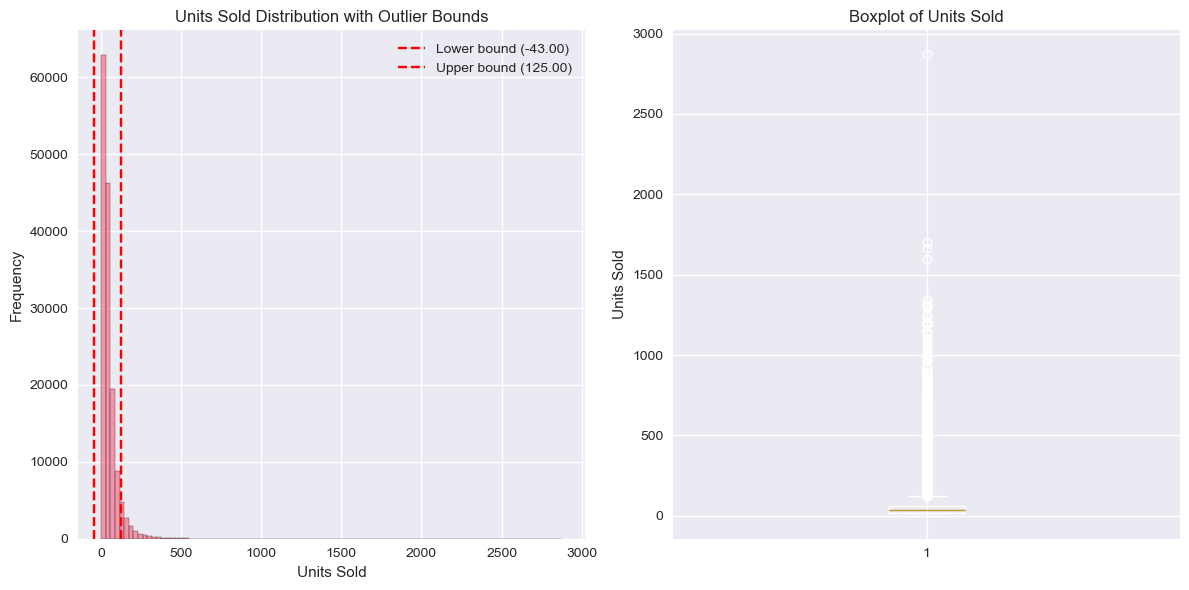

In [26]:
# Visualize outliers
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_data['units_sold'], bins=100, edgecolor='black', alpha=0.7)
plt.axvline(lower_bound, color='r', linestyle='--', label=f'Lower bound ({lower_bound:.2f})')
plt.axvline(upper_bound, color='r', linestyle='--', label=f'Upper bound ({upper_bound:.2f})')
plt.title('Units Sold Distribution with Outlier Bounds')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(train_data['units_sold'])
plt.title('Boxplot of Units Sold')
plt.ylabel('Units Sold')

plt.tight_layout()
plt.show()

In [27]:
# Check outliers in price variables
price_outliers_total, _, _ = detect_outliers_iqr(train_data, 'total_price')
price_outliers_base, _, _ = detect_outliers_iqr(train_data, 'base_price')

print(f"Outliers in total_price: {len(price_outliers_total)} ({len(price_outliers_total)/len(train_data)*100:.2f}%)")
print(f"Outliers in base_price: {len(price_outliers_base)} ({len(price_outliers_base)/len(train_data)*100:.2f}%)")

Outliers in total_price: 12028 (8.01%)
Outliers in base_price: 17123 (11.40%)


## 4. 数据预处理

In [28]:
# Handle missing values
# Check the specific missing value in total_price
missing_price_rows = train_data[train_data['total_price'].isnull()]
print("Rows with missing total_price in training data:")
display(missing_price_rows)

# Impute missing value with base_price (reasonable assumption when no discount)
train_data['total_price'].fillna(train_data['base_price'], inplace=True)
print("\nMissing values after imputation:")
print(train_data.isnull().sum())

Rows with missing total_price in training data:


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
136949,193915,2023-04-13,9436,245338,NaN,469.5375,0,0,1



Missing values after imputation:
record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64


In [29]:
# Check for duplicates
duplicates_train = train_data.duplicated().sum()
duplicates_test = test_data.duplicated().sum()

print(f"Duplicate rows in training data: {duplicates_train}")
print(f"Duplicate rows in test data: {duplicates_test}")

# Remove duplicates if any
if duplicates_train > 0:
    train_data = train_data.drop_duplicates()
    print(f"Removed {duplicates_train} duplicate rows from training data")
    
if duplicates_test > 0:
    test_data = test_data.drop_duplicates()
    print(f"Removed {duplicates_test} duplicate rows from test data")

Duplicate rows in training data: 0
Duplicate rows in test data: 0


In [30]:
# Data type optimization
def optimize_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            if df[col].min() >= 0 and df[col].max() <= 255:
                df[col] = df[col].astype('uint8')
            elif df[col].min() >= -128 and df[col].max() <= 127:
                df[col] = df[col].astype('int8')
            elif df[col].min() >= 0 and df[col].max() <= 65535:
                df[col] = df[col].astype('uint16')
            elif df[col].min() >= -32768 and df[col].max() <= 32767:
                df[col] = df[col].astype('int16')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    return df

# Optimize data types
initial_memory_train = train_data.memory_usage(deep=True).sum() / 1024**2
initial_memory_test = test_data.memory_usage(deep=True).sum() / 1024**2

train_data = optimize_dtypes(train_data)
test_data = optimize_dtypes(test_data)

final_memory_train = train_data.memory_usage(deep=True).sum() / 1024**2
final_memory_test = test_data.memory_usage(deep=True).sum() / 1024**2

print(f"Training data memory reduced from {initial_memory_train:.2f} MB to {final_memory_train:.2f} MB ({(initial_memory_train-final_memory_train)/initial_memory_train*100:.1f}% reduction)")
print(f"Test data memory reduced from {initial_memory_test:.2f} MB to {final_memory_test:.2f} MB ({(initial_memory_test-final_memory_test)/initial_memory_test*100:.1f}% reduction)")

Training data memory reduced from 10.31 MB to 5.44 MB (47.2% reduction)
Test data memory reduced from 0.85 MB to 0.48 MB (43.7% reduction)


## 5. 特征工程

In [31]:
# Create time-based features
def create_time_features(df):
    df = df.copy()
    df['year'] = df['week'].dt.year
    df['month'] = df['week'].dt.month
    df['day_of_week'] = df['week'].dt.dayofweek
    df['day_of_month'] = df['week'].dt.day
    df['quarter'] = df['week'].dt.quarter
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    return df

train_data = create_time_features(train_data)
test_data = create_time_features(test_data)

print("Time-based features created successfully!")
print("New columns in training data:", [col for col in train_data.columns if col not in ['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'units_sold'] and col not in train_data.columns[:9]])

Time-based features created successfully!
New columns in training data: ['year', 'month', 'day_of_week', 'day_of_month', 'quarter', 'is_weekend']


In [32]:
# Create price-based features
def create_price_features(df):
    df = df.copy()
    # Price difference and discount ratio
    df['price_discount'] = df['base_price'] - df['total_price']
    df['discount_ratio'] = df['price_discount'] / (df['base_price'] + 1e-8)  # Adding small epsilon to avoid division by zero
    
    # Log transformations
    df['log_total_price'] = np.log1p(df['total_price'])
    df['log_base_price'] = np.log1p(df['base_price'])
    
    # Price ratios
    df['price_ratio'] = df['total_price'] / (df['base_price'] + 1e-8)
    
    return df

train_data = create_price_features(train_data)
test_data = create_price_features(test_data)

print("Price-based features created successfully!")

Price-based features created successfully!


In [33]:
# Create promotion features
def create_promotion_features(df):
    df = df.copy()
    # Combined promotion flag
    df['is_promoted'] = ((df['is_featured_sku'] == 1) | (df['is_display_sku'] == 1)).astype(int)
    
    # Promotion intensity
    df['promotion_intensity'] = df['is_featured_sku'] + df['is_display_sku']
    
    return df

train_data = create_promotion_features(train_data)
test_data = create_promotion_features(test_data)

print("Promotion features created successfully!")

Promotion features created successfully!


In [34]:
# Display all engineered features
print("Engineered features in training data:")
feature_columns = [col for col in train_data.columns if col not in ['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'units_sold']]
print(feature_columns)

print("\nEngineered features in test data:")
feature_columns_test = [col for col in test_data.columns if col not in ['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku']]
print(feature_columns_test)

Engineered features in training data:
['year', 'month', 'day_of_week', 'day_of_month', 'quarter', 'is_weekend', 'price_discount', 'discount_ratio', 'log_total_price', 'log_base_price', 'price_ratio', 'is_promoted', 'promotion_intensity']

Engineered features in test data:
['year', 'month', 'day_of_week', 'day_of_month', 'quarter', 'is_weekend', 'price_discount', 'discount_ratio', 'log_total_price', 'log_base_price', 'price_ratio', 'is_promoted', 'promotion_intensity']


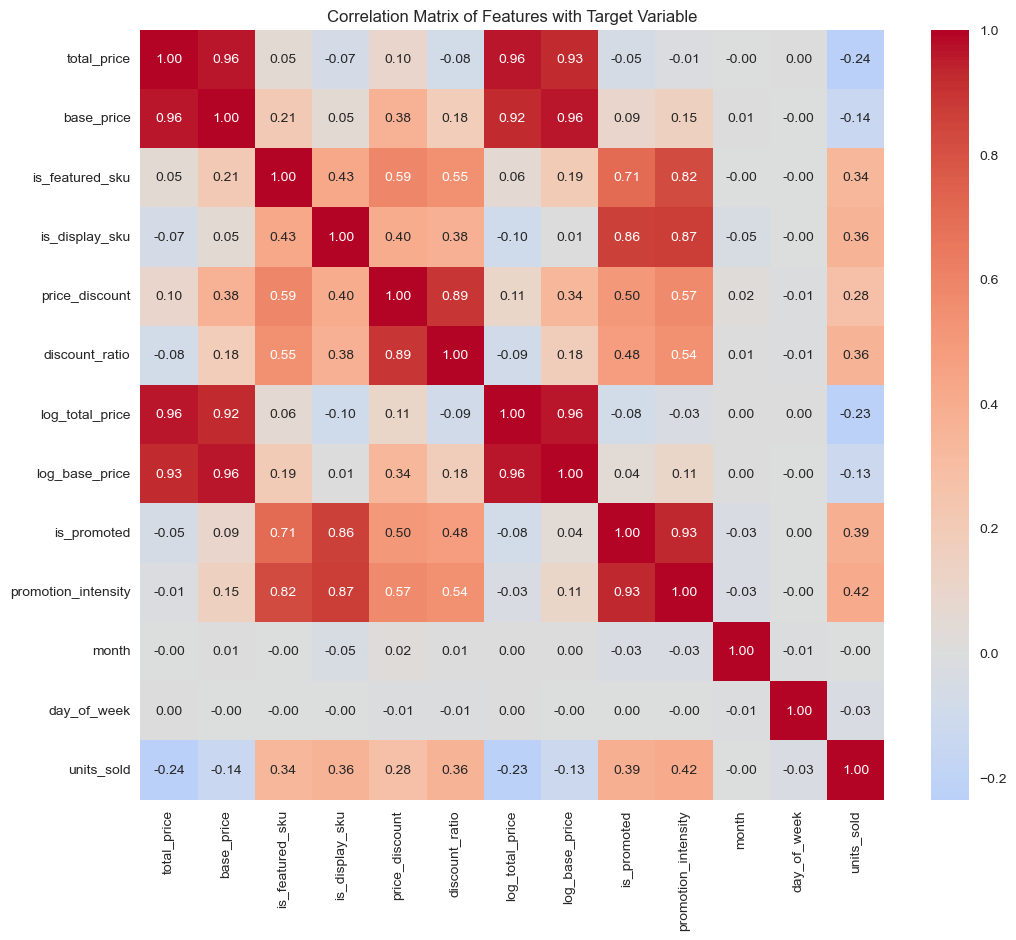

In [35]:
# Correlation analysis of engineered features with target
feature_cols = ['total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'price_discount', 'discount_ratio', 'log_total_price', 'log_base_price', 'is_promoted', 'promotion_intensity', 'month', 'day_of_week']

correlation_data = train_data[feature_cols + ['units_sold']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Features with Target Variable')
plt.show()

## 6. 数据拆分与验证

In [36]:
# Create time-based splits for validation
print("Creating time-based splits for validation...")

# Sort data by date
train_data_sorted = train_data.sort_values('week').reset_index(drop=True)

# Define split points (using last 20% as validation)
split_idx = int(len(train_data_sorted) * 0.8)

train_split = train_data_sorted[:split_idx]
val_split = train_data_sorted[split_idx:]

print(f"Training split: {len(train_split)} samples ({len(train_split)/len(train_data_sorted)*100:.1f}% of data)")
print(f"Validation split: {len(val_split)} samples ({len(val_split)/len(train_data_sorted)*100:.1f}% of data)")

print(f"\nTraining period: {train_split['week'].min()} to {train_split['week'].max()}")
print(f"Validation period: {val_split['week'].min()} to {val_split['week'].max()}")

Creating time-based splits for validation...
Training split: 120120 samples (80.0% of data)
Validation split: 30030 samples (20.0% of data)

Training period: 2001-01-13 00:00:00 to 2025-07-11 00:00:00
Validation period: 2025-09-12 00:00:00 to 2031-10-11 00:00:00


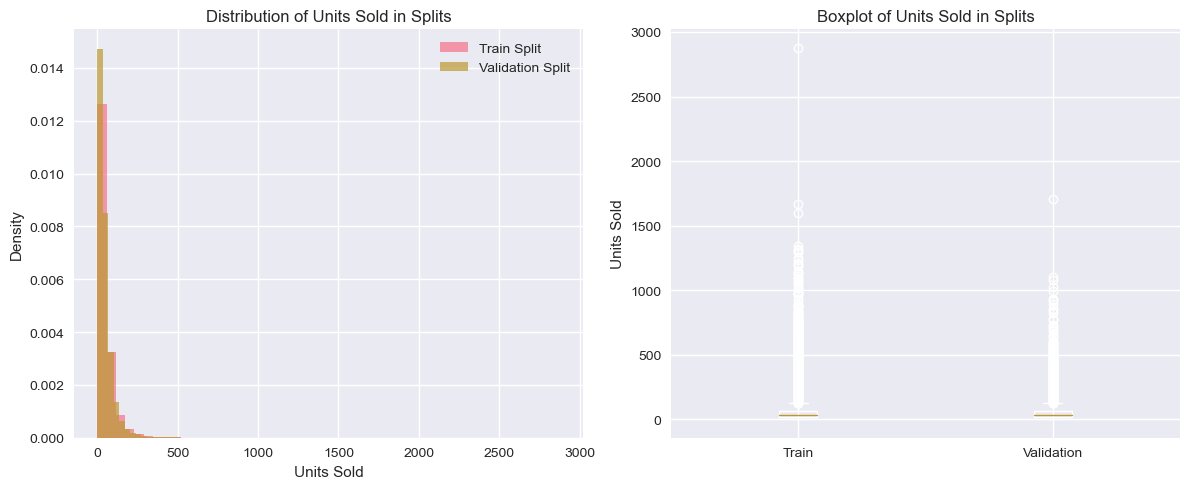

Train split - Mean units_sold: 52.04, Std: 61.35
Validation split - Mean units_sold: 50.22, Std: 55.39


In [37]:
# Check distribution of target variable in splits
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_split['units_sold'], bins=50, alpha=0.7, label='Train Split', density=True)
plt.hist(val_split['units_sold'], bins=50, alpha=0.7, label='Validation Split', density=True)
plt.title('Distribution of Units Sold in Splits')
plt.xlabel('Units Sold')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot([train_split['units_sold'], val_split['units_sold']], labels=['Train', 'Validation'])
plt.title('Boxplot of Units Sold in Splits')
plt.ylabel('Units Sold')

plt.tight_layout()
plt.show()

print(f"Train split - Mean units_sold: {train_split['units_sold'].mean():.2f}, Std: {train_split['units_sold'].std():.2f}")
print(f"Validation split - Mean units_sold: {val_split['units_sold'].mean():.2f}, Std: {val_split['units_sold'].std():.2f}")

In [38]:
# Final dataset summary
print("=== FINAL DATASET SUMMARY ===")
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"\nColumns in training data: {list(train_data.columns)}")
print(f"\nColumns in test data: {list(test_data.columns)}")

# Save processed data
train_data.to_csv('../archive/train_processed.csv', index=False)
test_data.to_csv('../archive/test_processed.csv', index=False)
print("\nProcessed data saved to archive folder.")

=== FINAL DATASET SUMMARY ===
Training data shape: (150150, 22)
Test data shape: (13860, 21)

Columns in training data: ['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'units_sold', 'year', 'month', 'day_of_week', 'day_of_month', 'quarter', 'is_weekend', 'price_discount', 'discount_ratio', 'log_total_price', 'log_base_price', 'price_ratio', 'is_promoted', 'promotion_intensity']

Columns in test data: ['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'year', 'month', 'day_of_week', 'day_of_month', 'quarter', 'is_weekend', 'price_discount', 'discount_ratio', 'log_total_price', 'log_base_price', 'price_ratio', 'is_promoted', 'promotion_intensity']

Processed data saved to archive folder.


## 总结
完成了完整的数据分析pipeline：
1. **数据加载**：加载训练和测试数据集
2. **探索性数据分析**：分析分布、相关性和模式
3. **异常值检测**：使用IQR方法识别异常值
4. **数据预处理**：处理缺失值、删除重复项、优化数据类型
5. **特征工程**：创建了基于时间、基于价格、基于促销的特征
6. **数据拆分**：创建基于时间的训练集/验证集拆分

接下来进行机器学习建模...
